In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [5]:
file_path = '/Users/harshitgupta/Desktop/vs /VS-Data-Den/data_cleaning/filled_model_dataset.csv'

In [6]:
df = pd.read_csv(file_path)


In [7]:
df['TOTAL_SALES'].fillna(0, inplace=True)

/var/folders/_p/ljb0l43112vc95swz8nhgv340000gn/T/ipykernel_52079/2900868314.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TOTAL_SALES'].fillna(0, inplace=True)


In [8]:
df['YEARWEEK'] = pd.to_datetime(df['YEARWEEK'])
df['week_of_year'] = df['YEARWEEK'].dt.isocalendar().week

In [9]:
df['YEARWEEK'] = (df['YEARWEEK'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')



In [10]:
df.head()

,PTNR_REGIONAL_MASTER_CD,YEARWEEK,TOTAL_SALES,flag,week_of_year
0,0.0,1575763200,28994.45,active,49
1,0.0,1576368000,127699.87,active,50
2,0.0,1576972800,102609.00,active,51
3,0.0,1577577600,0.00,inactive,52
4,0.0,1578182400,0.00,inactive,1


In [11]:
# features = df[['PTNR_REGIONAL_MASTER_CD', 'YEARWEEK', 'week_of_year', 'flag']]
# target = df['TOTAL_SALES']

In [12]:
df['flag'] = df['flag'].map({'inactive': 0, 'active': 1})


In [13]:
features = df[['PTNR_REGIONAL_MASTER_CD', 'YEARWEEK', 'week_of_year', 'flag']]
target = df['TOTAL_SALES']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle= False)

In [15]:
train_data = lgb.Dataset(X_train, label=y_train)

In [16]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

In [17]:
# lgb_model = lgb.train(params, train_data, num_boost_round=1000)

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse'
}

In [19]:
lgb_model = lgb.train(params, train_data)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 14915, number of used features: 4
[LightGBM] [Info] Start training from score 301305.366601


In [20]:
y_pred = lgb_model.predict(X_test)

In [21]:
import matplotlib.pyplot as plt

In [22]:
X_test['YEARWEEK'] = pd.to_datetime(X_test['YEARWEEK'], unit='s')

In [23]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [24]:
mape = calculate_mape(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): inf%


In [25]:
result_df = pd.DataFrame({'YEARWEEK': X_test['YEARWEEK'], 'Actual': y_test, 'Predicted': y_pred, 'PTNR_REGIONAL_MASTER_CD': X_test['PTNR_REGIONAL_MASTER_CD']})


In [26]:
grouped = result_df.groupby('PTNR_REGIONAL_MASTER_CD')

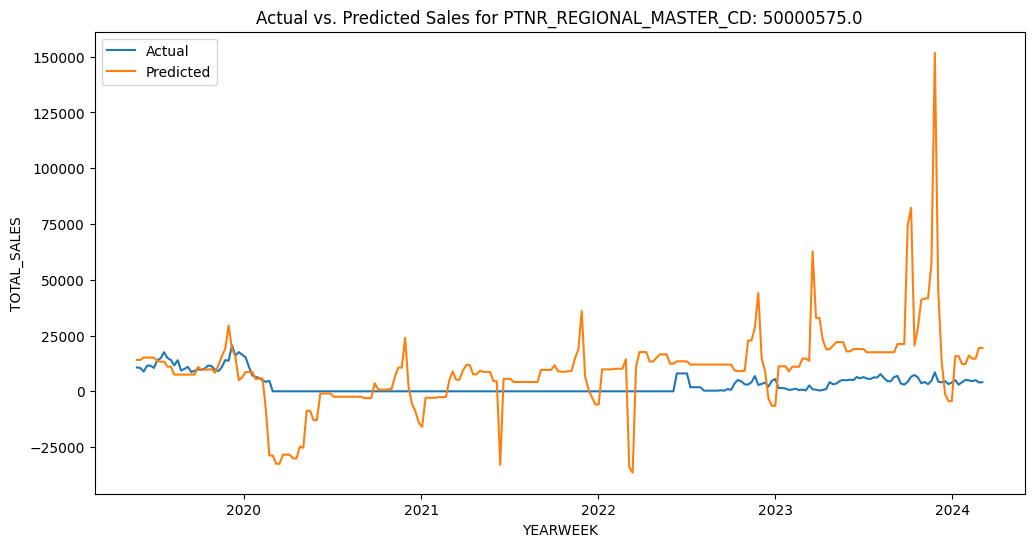

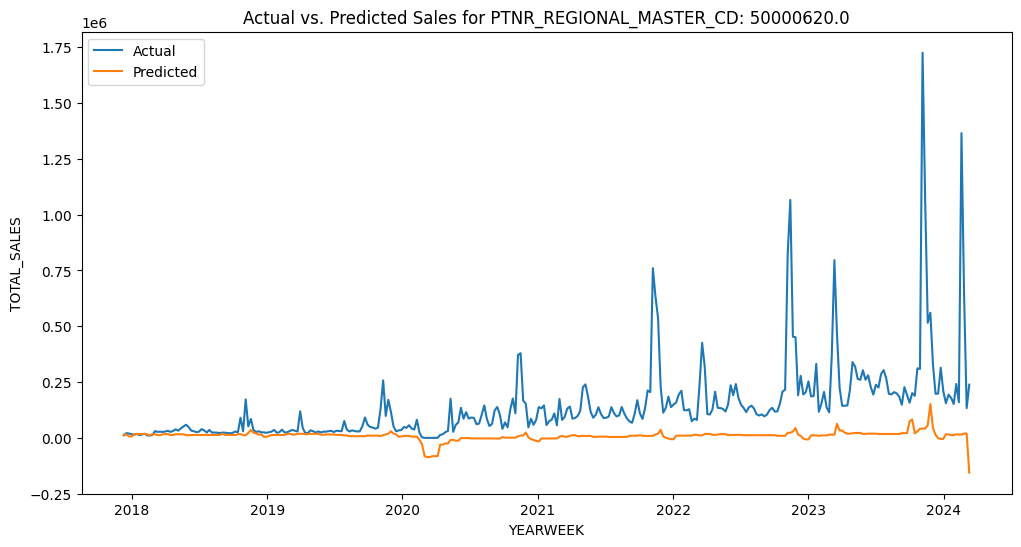

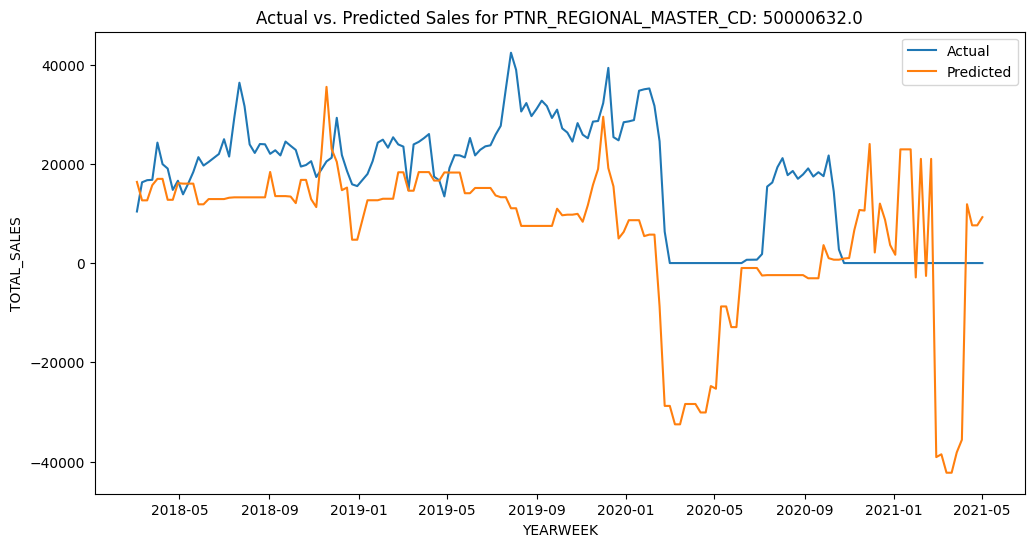

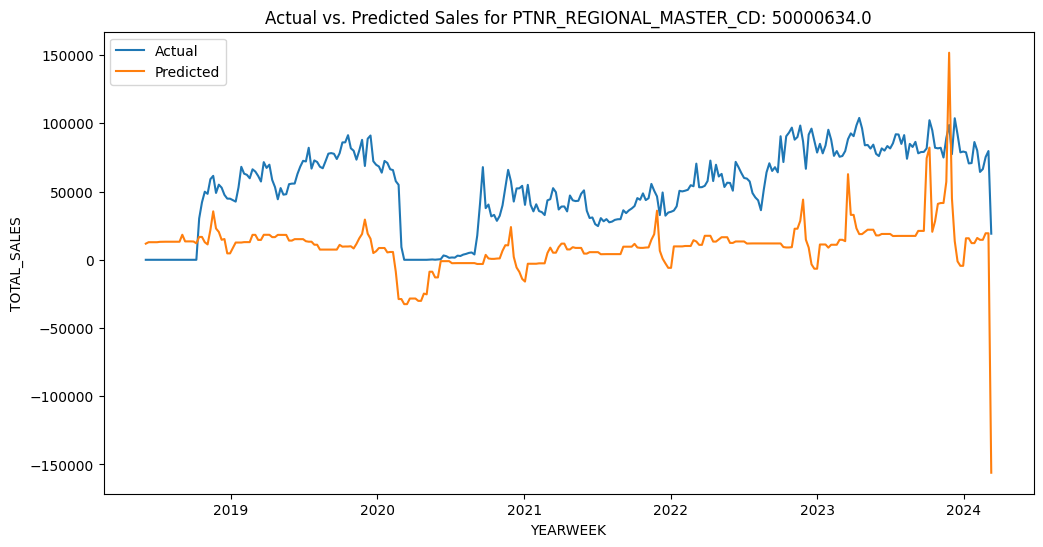

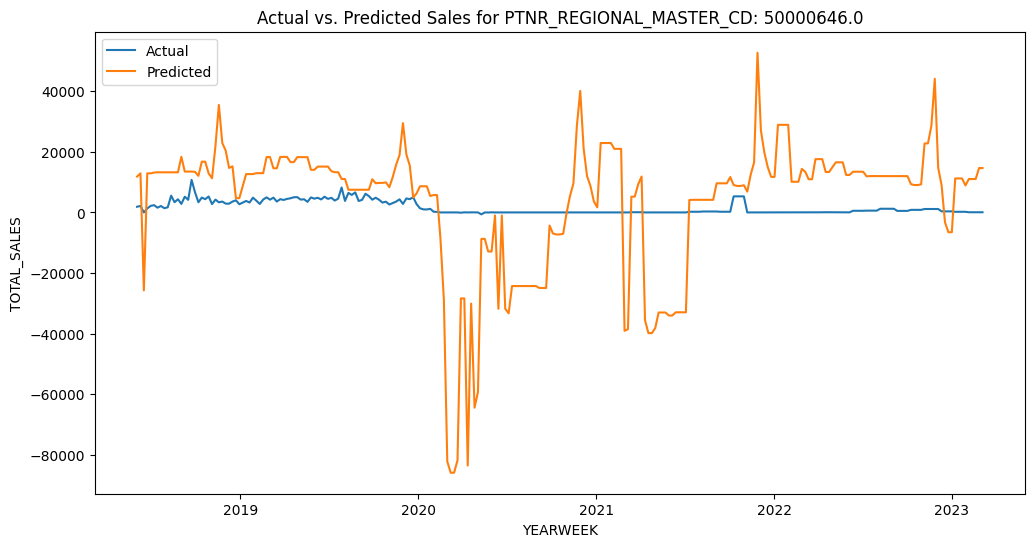

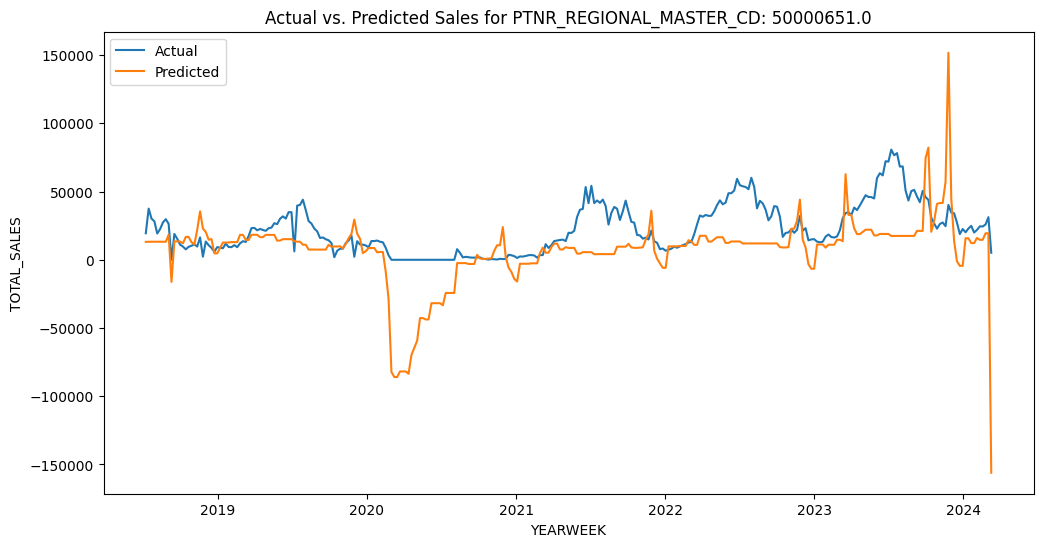

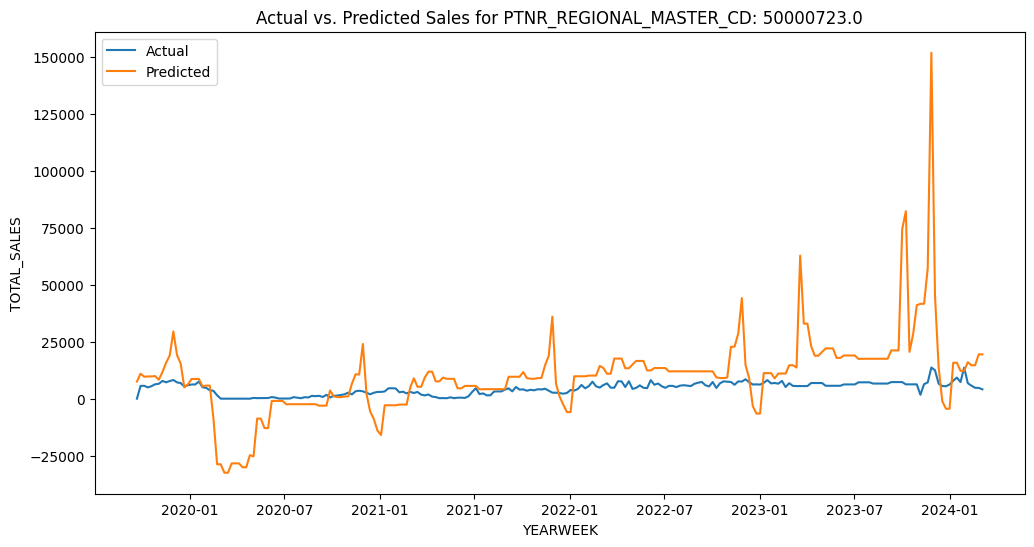

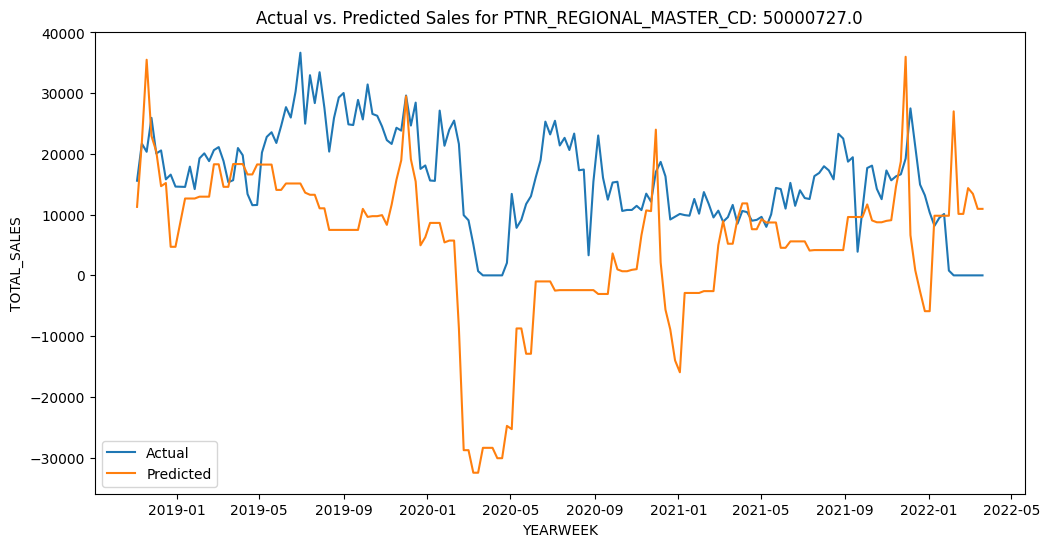

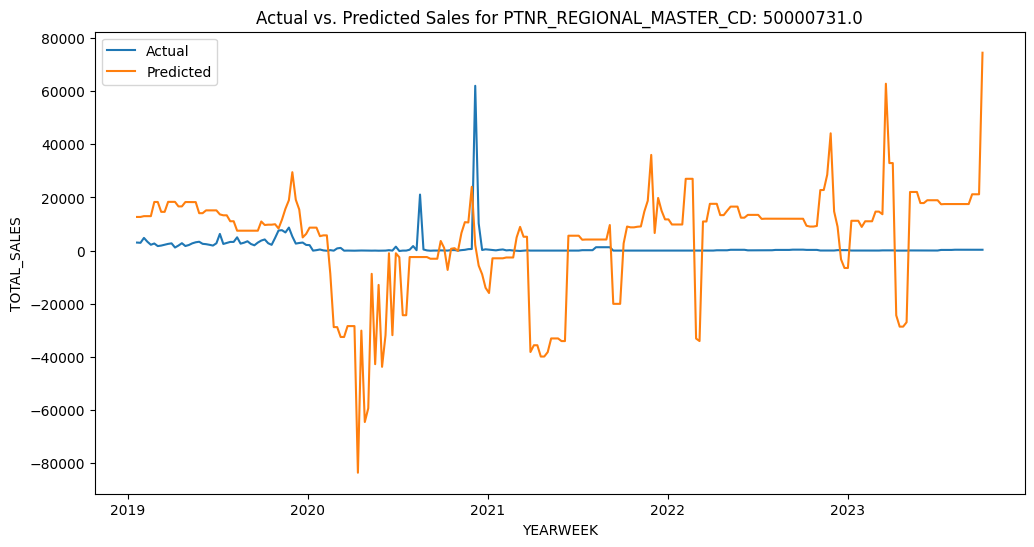

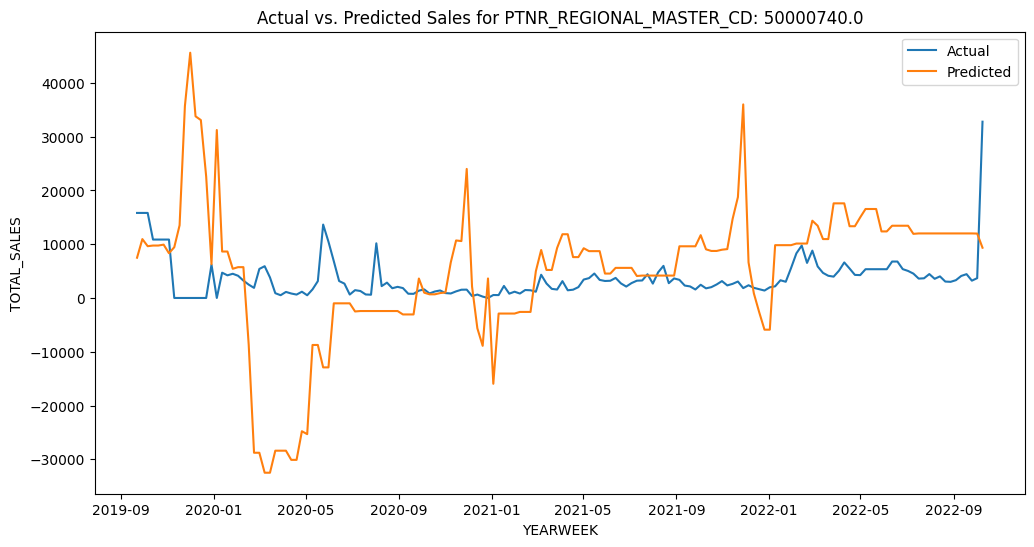

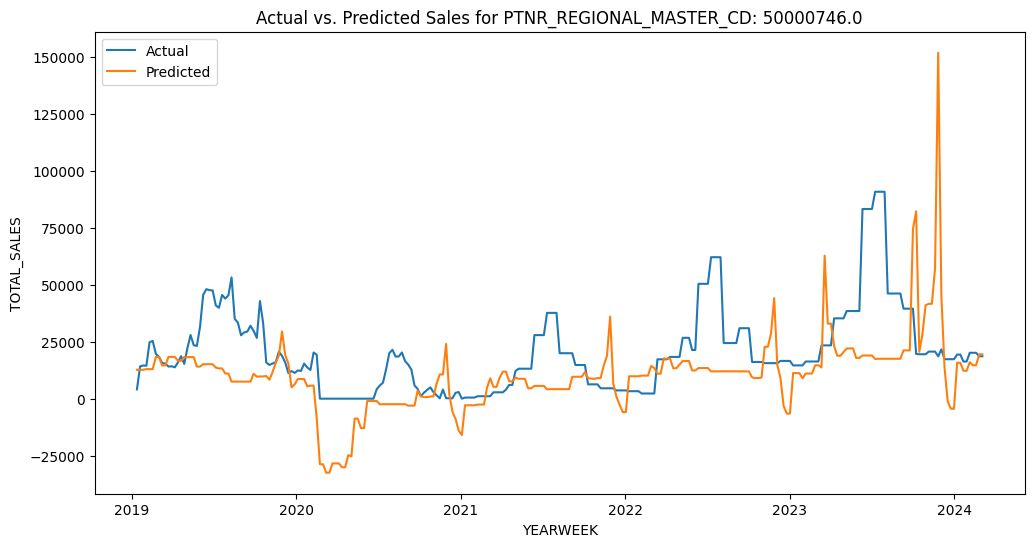

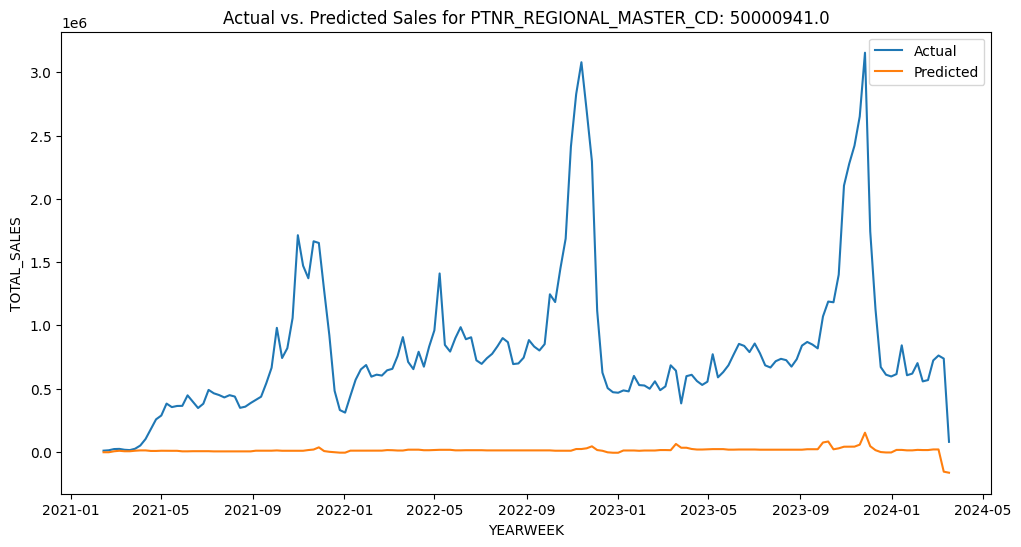

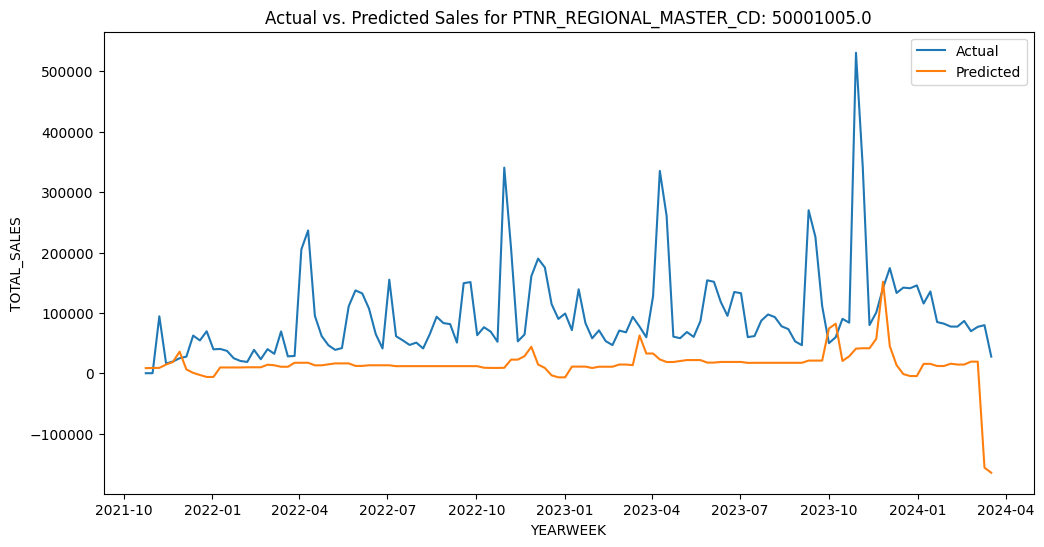

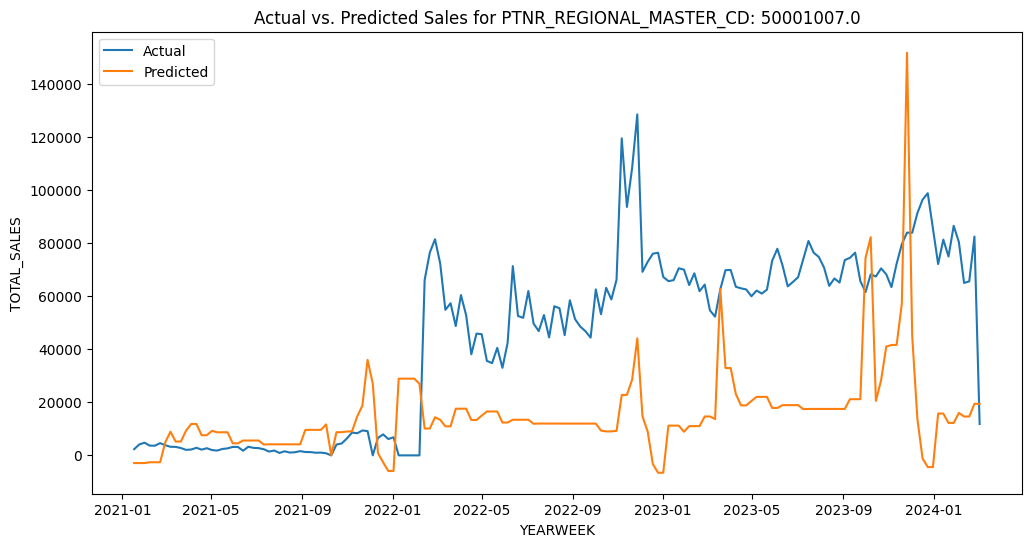

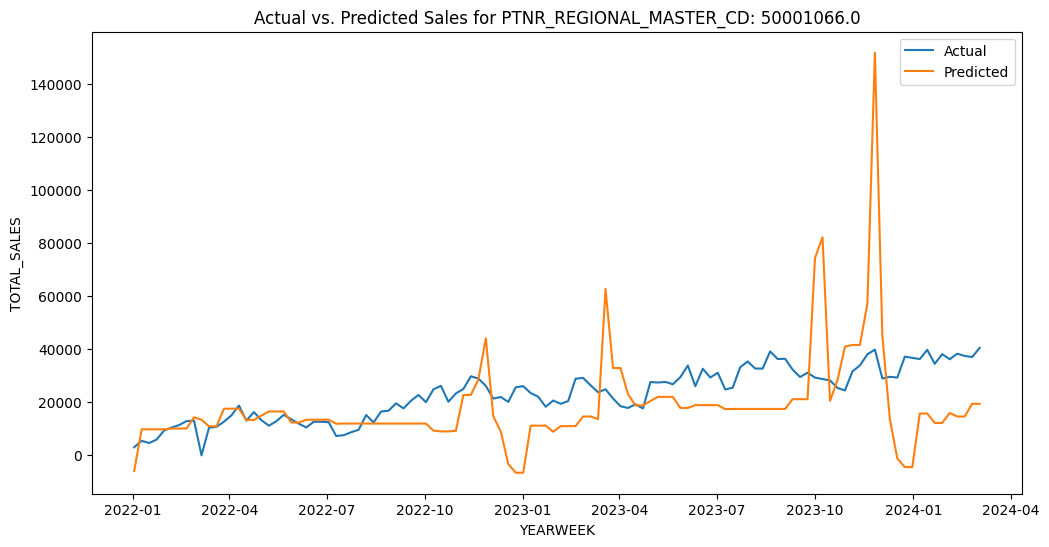

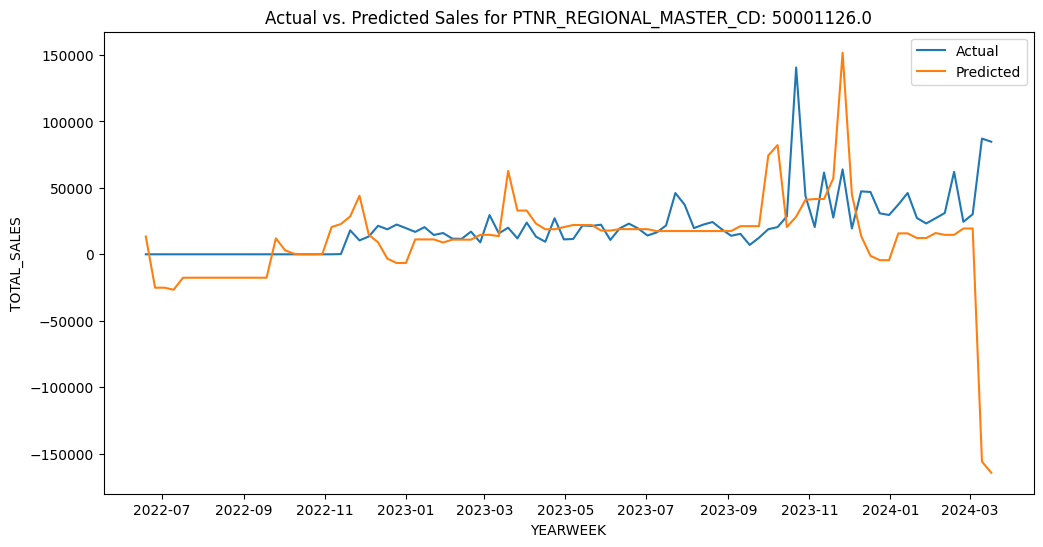

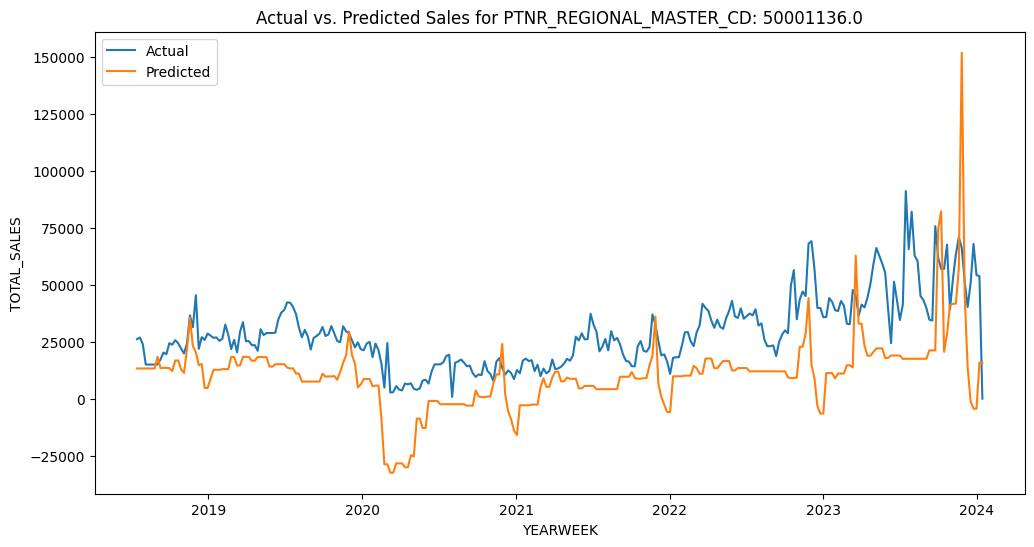

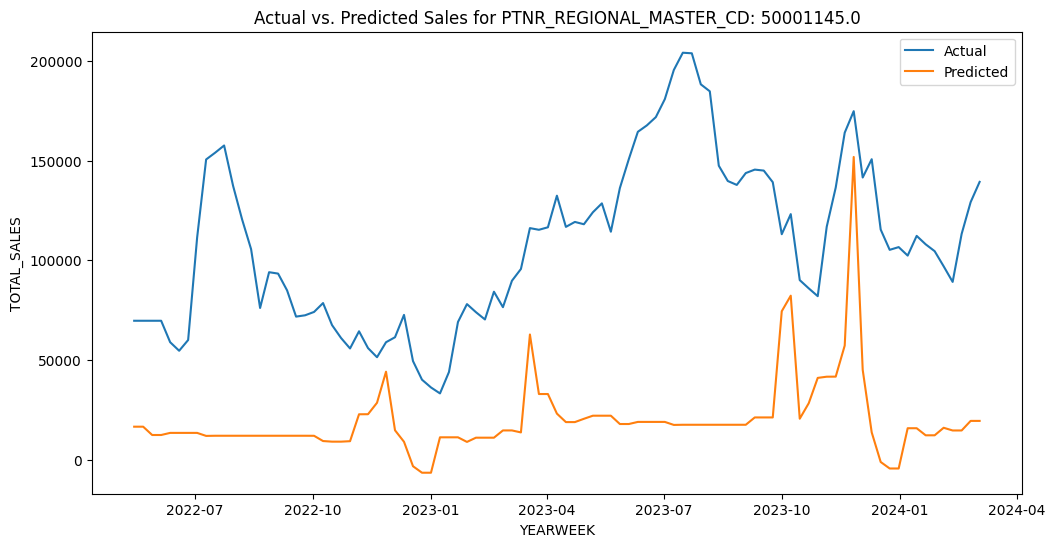

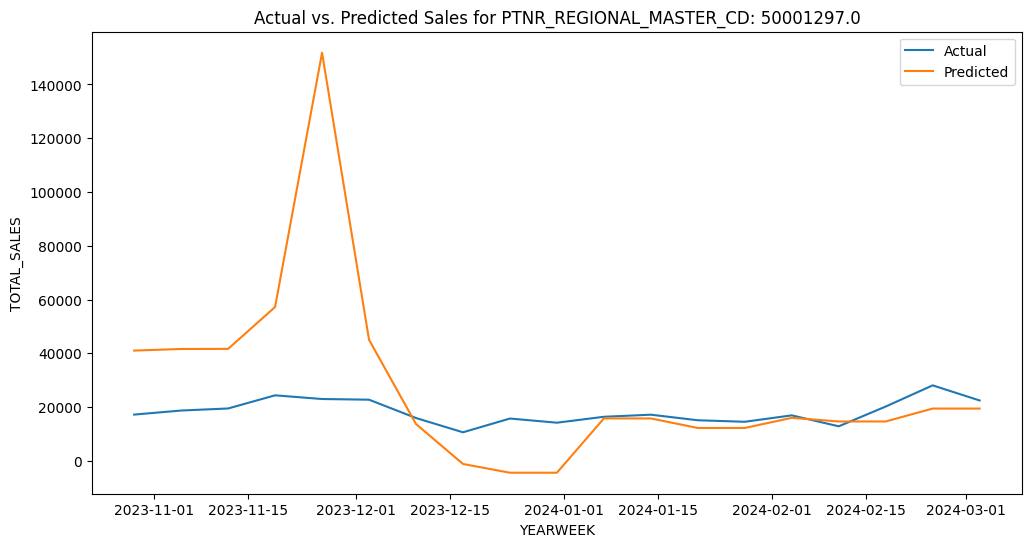

In [27]:
for master_cd, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.plot(group['YEARWEEK'], group['Actual'], label='Actual')
    plt.plot(group['YEARWEEK'], group['Predicted'], label='Predicted')
    plt.xlabel('YEARWEEK')
    plt.ylabel('TOTAL_SALES')
    plt.title(f'Actual vs. Predicted Sales for PTNR_REGIONAL_MASTER_CD: {master_cd}')
    plt.legend()
    plt.show()